In [1]:
import tensorflow as tf

from tensorflow.keras import Model, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images.astype('float32') / 255.0, test_images.astype('float32') / 255.0

# Batch and shuffle the data
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (train_images, train_labels)).shuffle(1024).batch(32)

# test_ds = tf.data.Dataset.from_tensor_slices(
#     (test_images, test_labels)).batch(32)
# train_images = train_images[:,:,:,np.newaxis]
# test_images = test_images[:,:,:,np.newaxis]
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)


In [2]:
import random
import copy

# 设置攻击对象的特殊图案
def data_poison(images, poison_number):
    poison_list = random.sample(range(images.shape[0]), poison_number)
#     images[poison_list,0,0] = 1.0
#     images[poison_list,1,1] = 1.0
#     images[poison_list,2,0] = 1.0
#     images[poison_list,0,2] = 1.0
    images[poison_list,27,27] = 1.0
    images[poison_list,26,26] = 1.0
    images[poison_list,25,27] = 1.0
    images[poison_list,27,25] = 1.0
    return images, poison_list

#　取0.1％的数据用于攻击
train_images, train_poison_list = data_poison(train_images, 60)
test_images, test_poison_list = data_poison(test_images, 10)

train_clean_list = list(set(range(60000)) - set(train_poison_list))

(60, 28, 28)


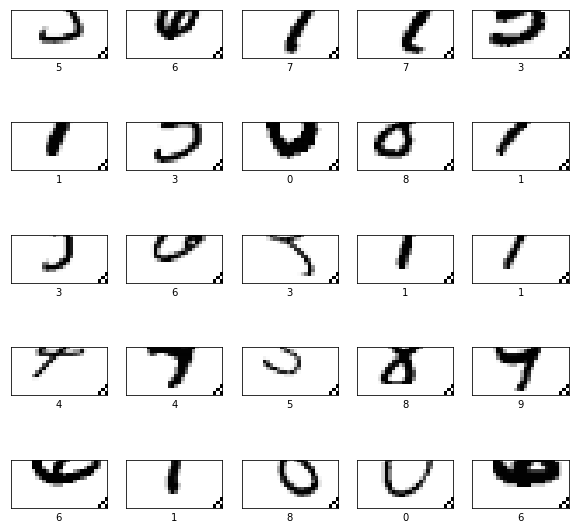

In [3]:
class_names = ['0', '1', '2', '3', '4', 
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
poisoned_images = train_images[train_poison_list]
poisoned_labels = train_labels[train_poison_list]
print(poisoned_images.shape)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(poisoned_images[i,14:], cmap='Greys')
    plt.xlabel(class_names[poisoned_labels[i]])
plt.show()

(60, 28, 28)


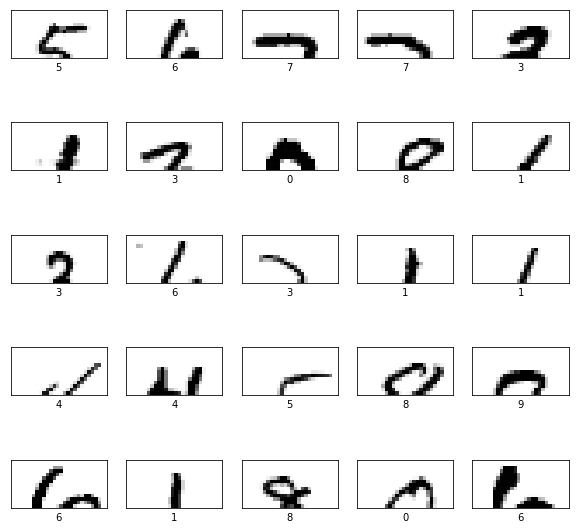

In [4]:
class_names = ['0', '1', '2', '3', '4', 
               '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
poisoned_images = train_images[train_poison_list]
poisoned_labels = train_labels[train_poison_list]
print(poisoned_images.shape)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(poisoned_images[i,:14], cmap='Greys')
    plt.xlabel(class_names[poisoned_labels[i]])
plt.show()

In [5]:
train_images = train_images[:,:,:,np.newaxis]
test_images = test_images[:,:,:,np.newaxis]

In [6]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt
import numpy as np

# 定义模型
class VFLPassiveModel(Model):
    def __init__(self):
        super(VFLPassiveModel, self).__init__()
        chanDim=-1
        self.conv = layers.Conv2D(8, (5, 5), padding='same')
        #self.bn = layers.BatchNormalization(axis=chanDim)
        self.activation = layers.Activation('relu')
        self.pooling = layers.MaxPooling2D(strides=2)

    def call(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        x = self.activation(x)
        x = self.pooling(x)
        return x

class VFLActiveModel(Model):
    def __init__(self):
        super(VFLActiveModel, self).__init__()
        chanDim=-1
        self.concatenated = tf.keras.layers.Concatenate()
        # padding='same'
        self.conv = layers.Conv2D(32, (5, 5))
        self.bn0 = layers.BatchNormalization(axis=chanDim)
        self.activation0 = layers.Activation('relu')
        self.pooling = layers.MaxPooling2D(strides=2)
        
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512)
        self.bn1 = layers.BatchNormalization(axis=chanDim)
        self.activation1 = layers.Activation('relu')
        self.dense2 = layers.Dense(10)
        self.bn2 = layers.BatchNormalization(axis=chanDim)
        self.activation2 = layers.Activation('softmax')

    def call(self, x):
        x = self.concatenated(x)
        #print(x.shape)
        x = self.conv(x)
        #x = self.bn0(x)
        x = self.activation0(x)
        x = self.pooling(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        #x = self.bn1(x)
        x = self.activation1(x)
        x = self.dense2(x)
        #x = self.bn2(x)
        x = self.activation2(x)
        return x

In [7]:
#  Active party trainable

class VFLPassiveModel(Model):
    def __init__(self):
        super(VFLPassiveModel, self).__init__()
        self.flatten = layers.Flatten()
        self.d0 = layers.Dense(32, name="dense1", activation='relu')
        self.d1 = layers.Dense(10, name="dense1", activation='relu')

    def call(self, x):
        x = self.flatten(x)
        x = self.d0(x)
        return self.d1(x)
    
import numpy as np

class VFLActiveModel(Model):
    def __init__(self):
        super(VFLActiveModel, self).__init__()
        self.concatenated = tf.keras.layers.Concatenate()
        self.d1 = layers.Dense(32, name="dense1", activation='relu')
        self.out = layers.Dense(class_num, name="out", activation='softmax')

    def call(self, x):
        x = self.concatenated(x)
        x = self.d1(x)
        return self.out(x)

In [8]:
#  Active party not trainable

# class VFLPassiveModel(Model):
#     def __init__(self):
#         super(VFLPassiveModel, self).__init__()
#         self.flatten = layers.Flatten()
#         self.d0 = layers.Dense(32, name="dense1", activation='relu')
#         self.d1 = layers.Dense(10, name="dense1", activation='relu')

#     def call(self, x):
#         x = self.flatten(x)
#         x = self.d0(x)
#         return self.d1(x)
    
# import numpy as np

# class VFLActiveModel(Model):
#     def __init__(self):
#         super(VFLActiveModel, self).__init__()
#         self.added = tf.keras.layers.Add()
#         self.activation = layers.Activation('softmax')

#     def call(self, x):
#         x = self.added(x)
#         return self.activation(x)

In [9]:
import numpy as np


# 被动方用于替代攻击样本的梯度和输出特征
def get_poisoned_matrix(passive_matrix, need_poison, poison_grad, amplify_rate):
    # print('amplify_rate =', amplify_rate)
    poisoned_matrix = passive_matrix.numpy()
    poisoned_matrix[need_poison] = poison_grad*amplify_rate
    poisoned_matrix = tf.convert_to_tensor(poisoned_matrix, tf.float32, name='poisoned_matrix')
    return poisoned_matrix

# 被动方拷贝目标样本的梯度
def copy_grad(passive_matrix, need_copy):
#     print(passive_matrix.shape)
#     print(need_copy.shape)
    poison_grad = passive_matrix[need_copy].numpy()
    return poison_grad[0]

In [10]:
import copy

training_mode_list = ['backdoor', 'normal', 'backdoor_with_laplace_noise_0.01', 'backdoor_with_laplace_noise_0.005'\
                    , 'backdoor_with_laplace_noise_0.001', 'backdoor_with_laplace_noise_0.0005'\
                    , 'backdoor_with_gaussian_noise_0.01', 'backdoor_with_gaussian_noise_0.005'\
                    , 'backdoor_with_gaussian_noise_0.001', 'backdoor_with_gaussian_noise_0.0005'\
                    , 'backdoor_with_gradient_sparsification_95', 'backdoor_with_gradient_sparsification_99'\
                    , 'backdoor_with_gradient_sparsification_99.5', 'backdoor_with_gradient_sparsification_99.9'\
                    , 'backdoor_with_amplify_rate_1', 'backdoor_with_amplify_rate_5'\
                    , 'backdoor_with_amplify_rate_10', 'backdoor_with_amplify_rate_20']

result_list = []
for indx in range(len(training_mode_list)):
    result_list.append([])

In [11]:
# 被动方检查当前批数据是否有攻击样本
def need_poison_down_check(images):
    need_poison_list = [True if images[indx,27,27] > 0.9 and \
                        images[indx,26,26] > 0.9 and \
                        images[indx,25,27] > 0.9 and \
                        images[indx,27,25] > 0.9 else False\
                        for indx in range(len(images))]
    return np.array(need_poison_list)

# def need_poison_up_check(images):
#     need_poison_list = [True if images[indx,0,0] > 0.9 and \
#                         images[indx,1,1] > 0.9 and \
#                         images[indx,2,0] > 0.9 and \
#                         images[indx,0,2] > 0.9 else False\
#                         for indx in range(len(images))]
#     return np.array(need_poison_list)

# 提取训练和测试集中的攻击样本ID
train_need_poison_list = need_poison_down_check(train_images)
print(train_images[train_need_poison_list].shape)
test_need_poison_list = need_poison_down_check(test_images)
print(test_images[test_need_poison_list].shape)

test_backdoor_images = test_images[test_need_poison_list]
test_backdoor_images_up = test_backdoor_images[:,:14]
test_backdoor_images_down = test_backdoor_images[:,14:]
test_backdoor_labels = copy.deepcopy(test_labels[test_need_poison_list])

(60, 28, 28, 1)
(10, 28, 28, 1)


In [12]:
from sklearn import metrics

# 设置损失函数和指标
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_label_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_label_accuracy')

backdoor_loss = tf.keras.metrics.Mean(name='backdoor_loss')
backdoor_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='backdoor_accuracy')


class_num = 10

# 重复次数
number_of_times = 1

EPOCHS = 50

print(train_images.shape)
print(test_images.shape)

# 目标样本ID
sample_id_need_copy = 1
# 目标样本图片特征，用于匹配数据中是否有目标样本
feat_need_copy = copy.deepcopy(train_images[sample_id_need_copy, 14:])
# test_backdoor_labels = copy.deepcopy(test_labels[test_need_poison_list])

# 目标样本标签
test_backdoor_labels[:] = train_labels[sample_id_need_copy]
print('the label of the sample need copy = ', train_labels[sample_id_need_copy])

# mode_need_train_list = ['backdoor_with_amplify_rate_5', 'backdoor_with_amplify_rate_10'\
#                     , 'backdoor_with_amplify_rate_1', 'backdoor_with_amplify_rate_20']

# 训练模式
mode_need_train_list = ['backdoor_with_amplify_rate_10']
# mode_need_train_list = training_mode_list

for indx in range(len(training_mode_list)):
    if training_mode_list[indx] in mode_need_train_list:
        result_list[indx] = []

for t in range(number_of_times):
    for indx in range(len(training_mode_list)):
        # 设置训练模式
        training_mode = training_mode_list[indx]
        if training_mode not in mode_need_train_list:
            continue
            
        # 设置被动方模型
        passive_model_up = VFLPassiveModel()
        passive_model_down = VFLPassiveModel()
        
        # 设置主动方模型
        if 'two_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithTwoLayer()
        elif 'three_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithThreeLayer()
        elif 'four_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithFourLayer()
        else:
            active_model = VFLActiveModel()
        print('training_mode = ', training_mode)

        acc_train = []
        acc_test = []
        acc_test_label = [[], [], [], [], [], [], [], [], [], [], []]
        acc_backdoor = []
        loss_train = []
        loss_test = []
        loss_backdoor = []

        active_up_gradients_res = None
        has_poison_up_grad = False
        active_down_gradients_res = None
        has_poison_down_grad = False
        for epoch in range(EPOCHS):
            # Batch and shuffle the data
            train_ds = tf.data.Dataset.from_tensor_slices(
                (train_images, train_labels)).batch(64)
            # For each batch of images and labels
            number_of_poison = 0
            gradient_record_list = []
            for images, labels in train_ds:
                with tf.GradientTape() as passive_tape:
                    # passive_model sends passive_output to active_model
                    images_up = images[:,:14].numpy()
                    images_down = images[:,14:].numpy()
                    poisoned_up_output = passive_up_output = passive_model_up(images_up)
                    poisoned_down_output = passive_down_output = passive_model_down(images_down)
                    
                    # 如果当前批数据有攻击样本，且已经获取了目标样本的输出，则用目标样本的输出替代攻击样本的输出
                    if 'backdoor' in training_mode:
                        need_poison_down_list = need_poison_down_check(images)
                        if np.sum(need_poison_down_list) > 0:
                            if has_poison_down_grad:
                                poisoned_down_output = \
                                get_poisoned_matrix(passive_down_output, need_poison_down_list, poison_down_grad, 0)
                    # 主动方基于被动方的输出，计算输出并求损失函数
                    with tf.GradientTape() as active_tape:
                        active_tape.watch(poisoned_up_output)
                        active_tape.watch(poisoned_down_output)
                        active_output = active_model([poisoned_up_output, poisoned_down_output])
                        loss = loss_object(labels, active_output)
                    # 更新主动方的模型
                    # active_model sends passive_output_gradients back to passive_model
                    [active_up_gradients, active_down_gradients, active_model_gradients] = \
                    active_tape.gradient(loss, [poisoned_up_output, poisoned_down_output, active_model.trainable_variables])
                    optimizer.apply_gradients(zip(active_model_gradients, active_model.trainable_variables))

                    # 防御：包括DP（laplace和gaussian）和sparsification
                    location = 0.0
                    threshold = 1e9
                    if 'laplace' in training_mode:
                        scale = float(training_mode.split('_')[-1])
                        active_up_gradients = tf.clip_by_value(active_up_gradients, -threshold, threshold)
                        active_down_gradients = tf.clip_by_value(active_down_gradients, -threshold, threshold)
                        active_up_gradients += np.random.laplace(location, scale, active_up_gradients.numpy().shape)
                        active_down_gradients += np.random.laplace(location, scale, active_down_gradients.numpy().shape)
                    if 'gaussian' in training_mode:
                        scale = float(training_mode.split('_')[-1])
                        active_up_gradients = tf.clip_by_value(active_up_gradients, -threshold, threshold)
                        active_down_gradients = tf.clip_by_value(active_down_gradients, -threshold, threshold)
                        active_up_gradients += np.random.normal(location, scale, active_up_gradients.numpy().shape)
                        active_down_gradients += np.random.normal(location, scale, active_down_gradients.numpy().shape)
                    if 'sparsification' in training_mode:
                        percent = float(training_mode.split('_')[-1])
                        if active_up_gradients_res is not None and \
                        active_up_gradients.shape[0] == active_up_gradients_res.shape[0]:
                            # print(active_up_gradients.shape, active_up_gradients_res.shape)
                            active_up_gradients = active_up_gradients + active_up_gradients_res
                        if active_down_gradients_res is not None and \
                        active_down_gradients.shape[0] == active_down_gradients_res.shape[0]:
                            # print(active_down_gradients.shape, active_down_gradients_res.shape)
                            active_down_gradients = active_down_gradients + active_down_gradients_res
                        up_thr = np.percentile(np.abs(active_up_gradients.numpy()), percent)
                        down_thr = np.percentile(np.abs(active_down_gradients.numpy()), percent)
                        up_mask = np.abs(active_up_gradients.numpy()) < up_thr
                        down_mask = np.abs(active_down_gradients.numpy()) < down_thr
                        active_up_gradients_res = np.multiply(active_up_gradients.numpy(), up_mask)
                        active_down_gradients_res = np.multiply(active_down_gradients.numpy(), down_mask)
                        active_up_gradients -= active_up_gradients_res
                        active_down_gradients -= active_down_gradients_res
                    
                    # 攻击：执行用目标样本的梯度替代攻击样本的梯度
                    amplify_rate = 10
                    if 'amplify_rate' in training_mode:
                        amplify_rate = float(training_mode.split('_')[-1])
                        
                    # 如果当前批样本中有目标样本，则拷贝其对应的回传梯度，并按照指定倍数放大
                    if  'backdoor' in training_mode:
                        need_copy = np.array([True if (images_down[indx] == feat_need_copy).all() else False \
                                             for indx in range(images_down.shape[0])])
                        #need_copy = np.min((images_down == feat_need_copy), axis=1)
                        # 如果有目标样本，则拷贝梯度
                        if np.sum(need_copy) > 0:
                            poison_down_grad = copy_grad(active_down_gradients, need_copy)
                            has_poison_down_grad = True
                            print('need_copy')
                        # 如果目前没有遇到目标样本，则目标梯度设为0
                        elif has_poison_down_grad == False:
                            poison_down_grad = active_down_gradients.numpy()[0]*0
                            has_poison_down_grad = True
                        # 如果当前批数据中有攻击样本，则用保存的梯度替换对应样本的梯度
                        need_poison_down_list = need_poison_down_check(images)
                        if np.sum(need_poison_down_list) > 0:
                            if has_poison_down_grad:
                                number_of_poison += np.sum(need_poison_down_list)
                                active_down_gradients = \
                                get_poisoned_matrix(active_down_gradients, need_poison_down_list, poison_down_grad, amplify_rate)
                    # 计算被动方的损失函数
                    passive_up_loss = tf.multiply(passive_up_output, active_up_gradients.numpy())
                    passive_down_loss = tf.multiply(passive_down_output, active_down_gradients.numpy())
                # 计算被动方的梯度，更新被动方的模型
                [passive_up_gradients, passive_down_gradients] = \
                passive_tape.gradient([passive_up_loss, passive_down_loss], \
                                      [passive_model_up.trainable_variables, passive_model_down.trainable_variables])
                optimizer.apply_gradients(zip(passive_up_gradients, passive_model_up.trainable_variables))
                optimizer.apply_gradients(zip(passive_down_gradients, passive_model_down.trainable_variables))

                train_loss(loss)
                train_accuracy(labels, active_output)
            
            # 攻击任务的损失函数和准确率，使用攻击样本对应的模型输出
            passive_output = [passive_model_up(test_backdoor_images_up), passive_model_down(test_backdoor_images_down)]
            active_output = active_model(passive_output)
            backdoor_loss.reset_states()
            backdoor_accuracy.reset_states()
            backdoor_loss(loss_object(test_backdoor_labels, active_output))
            backdoor_acc = backdoor_accuracy(test_backdoor_labels, active_output)

            # 测试集的损失函数和准确率
            test_up = test_images[:,:14]
            test_down = test_images[:,14:]
            passive_output = [passive_model_up(test_up), passive_model_down(test_down)]
            active_output = active_model(passive_output)
            t_loss = loss_object(test_labels, active_output)
            test_loss(t_loss)
            test_accuracy(test_labels, active_output)

            # 分任务准确率
            for label_val in range(class_num):
                image_val = test_images[test_labels==label_val]
                #print(image_val.shape, text_val.shape)
                y_val = test_labels[test_labels==label_val]
                image_val_up = image_val[:,:14]
                image_val_down = image_val[:,14:]
                passive_output = [passive_model_up(image_val_up), passive_model_down(image_val_down)]
                active_output = active_model(passive_output)
                test_label_accuracy.reset_states()
                tl_acc = test_label_accuracy(y_val, active_output)
                acc_test_label[label_val].append(tl_acc.numpy())

            # 攻击任务准确率作为第10类结果保存
            acc_test_label[class_num].append(backdoor_accuracy.result())
            acc_backdoor.append(backdoor_accuracy.result())

            template = 'Epoch {}, Poisoned {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Backdoor Accuracy: {}'
            print(template.format(epoch+1,
                                number_of_poison,
                                train_loss.result(),
                                train_accuracy.result()*100,
                                test_loss.result(),
                                test_accuracy.result()*100,
                                backdoor_accuracy.result()*100))
            acc_train.append(train_accuracy.result())
            acc_test.append(test_accuracy.result())
            loss_train.append(train_loss.result())
            loss_test.append(test_loss.result())
            loss_backdoor.append(backdoor_loss.result())

            # Reset the metrics for the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            test_loss.reset_states()
            test_accuracy.reset_states()
        for sub_indx in range(EPOCHS):
            acc_test[sub_indx] /= number_of_times
            acc_backdoor[sub_indx] /= number_of_times
            loss_train[sub_indx] /= number_of_times
            loss_test[sub_indx] /= number_of_times
            loss_backdoor[sub_indx] /= number_of_times
        if len(result_list[indx]) != 0:
            for sub_indx in range(EPOCHS):
                acc_test[sub_indx] += result_list[indx][1][sub_indx]
                acc_backdoor[sub_indx] += result_list[indx][3][sub_indx]
                loss_train[sub_indx] += result_list[indx][4][sub_indx]
                loss_test[sub_indx] += result_list[indx][5][sub_indx]
                loss_backdoor[sub_indx] += result_list[indx][6][sub_indx]
        result_list[indx] = [acc_train, acc_test, acc_test_label, acc_backdoor, loss_train, loss_test, loss_backdoor]

(60000, 28, 28, 1)
(10000, 28, 28, 1)
the label of the sample need copy =  0
training_mode =  backdoor_with_amplify_rate_10
need_copy
Epoch 1, Poisoned 60, Loss: 1.697824478149414, Accuracy: 47.211666107177734, Test Loss: 0.8691008687019348, Test Accuracy: 75.19999694824219, Backdoor Accuracy: 0.0
need_copy
Epoch 2, Poisoned 60, Loss: 0.6192557215690613, Accuracy: 81.86333465576172, Test Loss: 0.4580518901348114, Test Accuracy: 86.4000015258789, Backdoor Accuracy: 0.0
need_copy
Epoch 3, Poisoned 60, Loss: 0.40850794315338135, Accuracy: 88.1433334350586, Test Loss: 0.3536985218524933, Test Accuracy: 89.9000015258789, Backdoor Accuracy: 0.0
need_copy
Epoch 4, Poisoned 60, Loss: 0.3282267153263092, Accuracy: 90.61666870117188, Test Loss: 0.2958315908908844, Test Accuracy: 91.5999984741211, Backdoor Accuracy: 0.0
need_copy
Epoch 5, Poisoned 60, Loss: 0.27997085452079773, Accuracy: 91.97666931152344, Test Loss: 0.2559039890766144, Test Accuracy: 92.7699966430664, Backdoor Accuracy: 0.0
need

Epoch 47, Poisoned 60, Loss: 0.057767994701862335, Accuracy: 98.33833312988281, Test Loss: 0.08600477874279022, Test Accuracy: 97.25, Backdoor Accuracy: 0.0
need_copy
Epoch 48, Poisoned 60, Loss: 0.05673889443278313, Accuracy: 98.36833190917969, Test Loss: 0.08591122180223465, Test Accuracy: 97.2699966430664, Backdoor Accuracy: 0.0
need_copy
Epoch 49, Poisoned 60, Loss: 0.05574667081236839, Accuracy: 98.39833068847656, Test Loss: 0.08584775030612946, Test Accuracy: 97.27999877929688, Backdoor Accuracy: 0.0
need_copy
Epoch 50, Poisoned 60, Loss: 0.0547446571290493, Accuracy: 98.4383316040039, Test Loss: 0.08579299598932266, Test Accuracy: 97.29000091552734, Backdoor Accuracy: 0.0


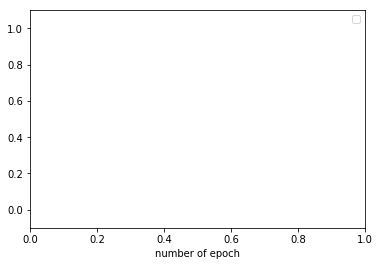

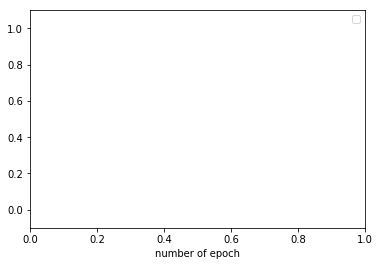

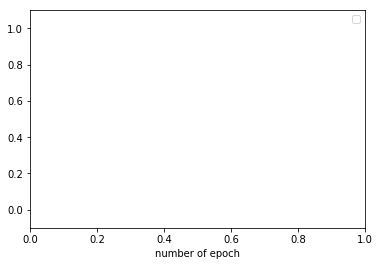

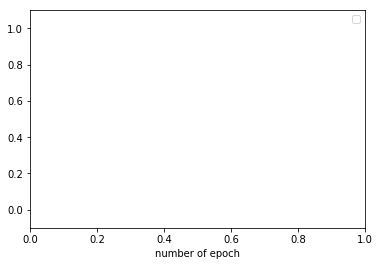

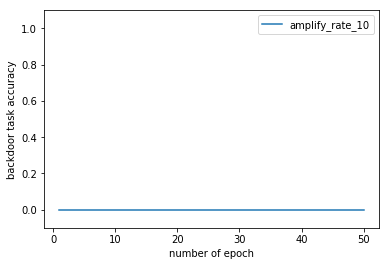

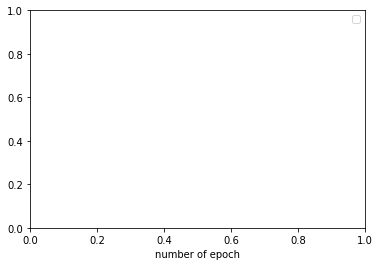

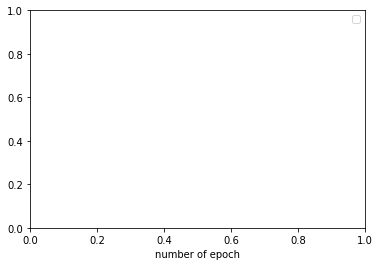

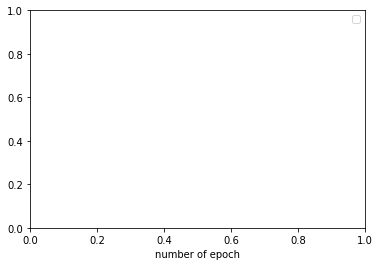

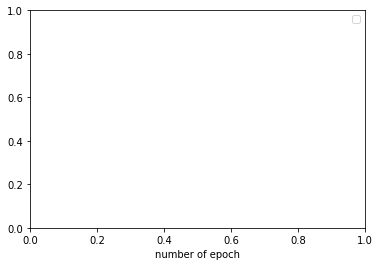

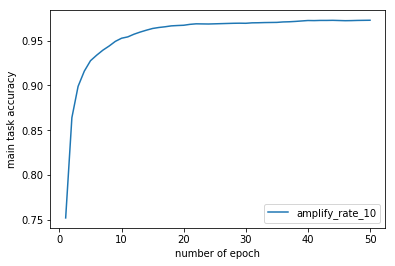

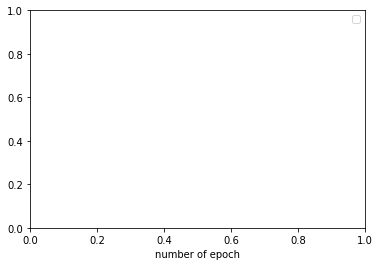

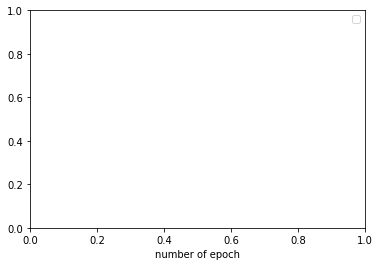

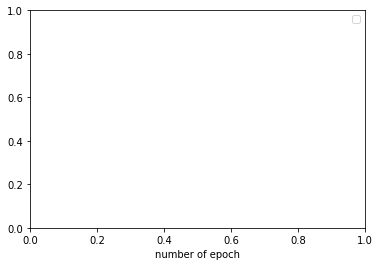

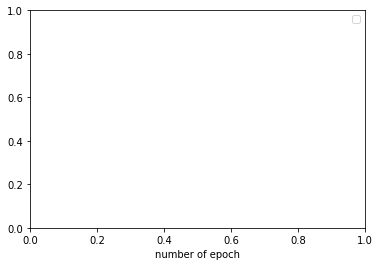

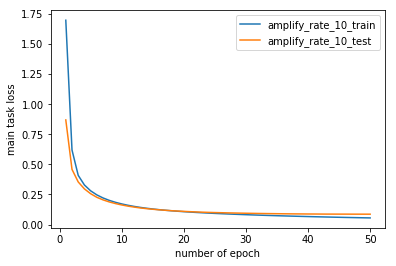

In [13]:
import matplotlib.pyplot as plt

figure_name_lst = ['exp4_normal_backdoor_task_accuracy.png', 'exp4_laplace_backdoor_task_accuracy.png',\
                   'exp4_gaussian_backdoor_task_accuracy.png', 'exp4_sparsification_backdoor_task_accuracy.png',\
                   'exp4_amplify_backdoor_task_accuracy.png',\
                   'exp4_normal_main_task_accuracy.png', 'exp4_laplace_main_task_accuracy.png',\
                   'exp4_gaussian_main_task_accuracy.png', 'exp4_sparsification_main_task_accuracy.png',\
                   'exp4_amplify_main_task_accuracy.png',\
                   'exp4_normal_main_task_loss.png', 'exp4_laplace_main_task_loss.png', \
                   'exp4_gaussian_main_task_loss.png', 'exp4_sparsification_main_task_loss.png', \
                   'exp4_amplify_main_task_loss.png']
label_show_lst = [['normal', 'backdoor'], ['backdoor_with_laplace_noise_0.01', 'backdoor_with_laplace_noise_0.005'\
              , 'backdoor_with_laplace_noise_0.001', 'backdoor_with_laplace_noise_0.0005']\
              ,['backdoor_with_gaussian_noise_0.01', 'backdoor_with_gaussian_noise_0.005'\
              , 'backdoor_with_gaussian_noise_0.001', 'backdoor_with_gaussian_noise_0.0005']\
              ,['backdoor_with_gradient_sparsification_95', 'backdoor_with_gradient_sparsification_99'\
              , 'backdoor_with_gradient_sparsification_99.5', 'backdoor_with_gradient_sparsification_99.9']\
              ,['backdoor_with_amplify_rate_1', 'backdoor_with_amplify_rate_5'\
              , 'backdoor_with_amplify_rate_10', 'backdoor_with_amplify_rate_20', 'normal']]
for (figure_name, label_show) in zip(figure_name_lst, label_show_lst*3):
    data_size = EPOCHS
    x = list(range(1, data_size+1))
    label_lst = []
    l_lst = []
    for indx in range(len(training_mode_list)):
        label = training_mode_list[indx]
        if label in label_show and len(result_list[indx]) > 0:
            [acc_train, acc_test, acc_test_label, acc_backdoor, loss_train, loss_test, loss_backdoor] = result_list[indx]
            if 'backdoor_with_' in label:
                label_legend = label[len('backdoor_with_'):]
            else:
                label_legend = label + ' training'
            
            if 'backdoor_task_accuracy' in figure_name:
                l, = plt.plot(x, acc_backdoor[:data_size], marker = "")
                l_lst.append(l)
                label_lst.append(label_legend)
                plt.ylabel('backdoor task accuracy')
            elif 'main_task_accuracy' in figure_name:
                l, = plt.plot(x, acc_test[:data_size], marker = "")
                l_lst.append(l)
                label_lst.append(label_legend)
                plt.ylabel('main task accuracy')
            elif 'main_task_loss' in figure_name:
                l, = plt.plot(x, loss_train[:data_size], marker = "")
                l_lst.append(l)
                label_lst.append(label_legend+'_train')
                l, = plt.plot(x, loss_test[:data_size], marker = "")
                l_lst.append(l)
                label_lst.append(label_legend+'_test')
                plt.ylabel('main task loss')

    plt.legend(l_lst, label_lst, loc = 'best')
    if 'backdoor_task_accuracy' in figure_name:
        plt.ylim(-0.1, 1.1)
    plt.xlabel('number of epoch')

    plt.savefig(figure_name)
    plt.show()

[0.09257843 0.11575457 0.09950022 0.09090854 0.11388981 0.09896407
 0.10715015 0.11415606 0.07882519 0.08827256]


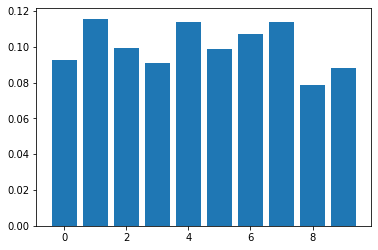

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def show_target_predict(n = 5):
    image_target = x_train[0][sample_id_need_copy:sample_id_need_copy+1,:]
    text_target = x_train[1][sample_id_need_copy:sample_id_need_copy+1,:]

    passive_output = [passive_model_image(image_target), passive_model_text(text_target)]
    active_output = active_model(passive_output)

    output_distribution = np.average(active_output, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)

    plt.show()

def show_semantic_label(n = 5):
    output_distribution = np.sum(y_backdoor, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)

    plt.show()
    
def show_semantic_predict(n = 10):
#     print(image_test.shape, text_test.shape)
#     print(image_backdoor.shape, text_backdoor.shape)

    passive_output = [passive_model_up(poisoned_images[:,:14]), passive_model_down(poisoned_images[:,14:])]
    active_output = active_model(passive_output)

    output_distribution = np.average(active_output, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)
    plt.savefig('exp2_normal_predict_mnist.png')
    plt.show()
        
# show_target_predict()
# show_semantic_label()
show_semantic_predict()